SIFT time: 0.053166866302490234
SURF time: 0.04751086235046387
(300, 564, 3)


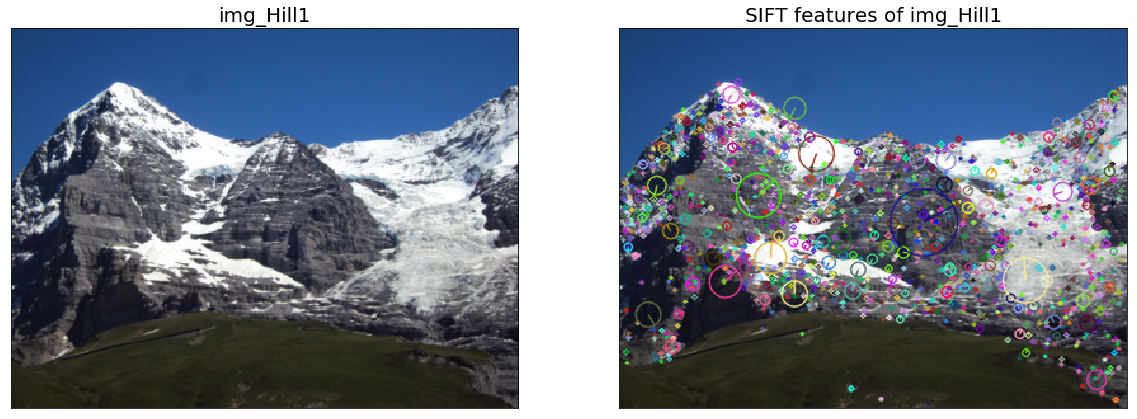

SIFT and SURF comparison


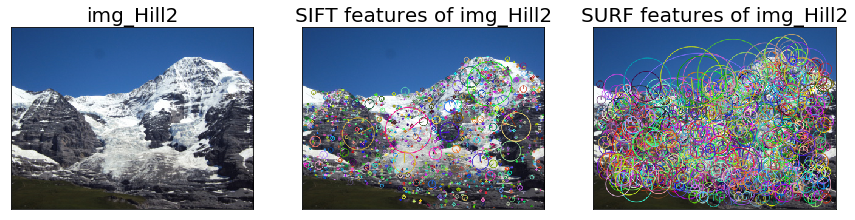

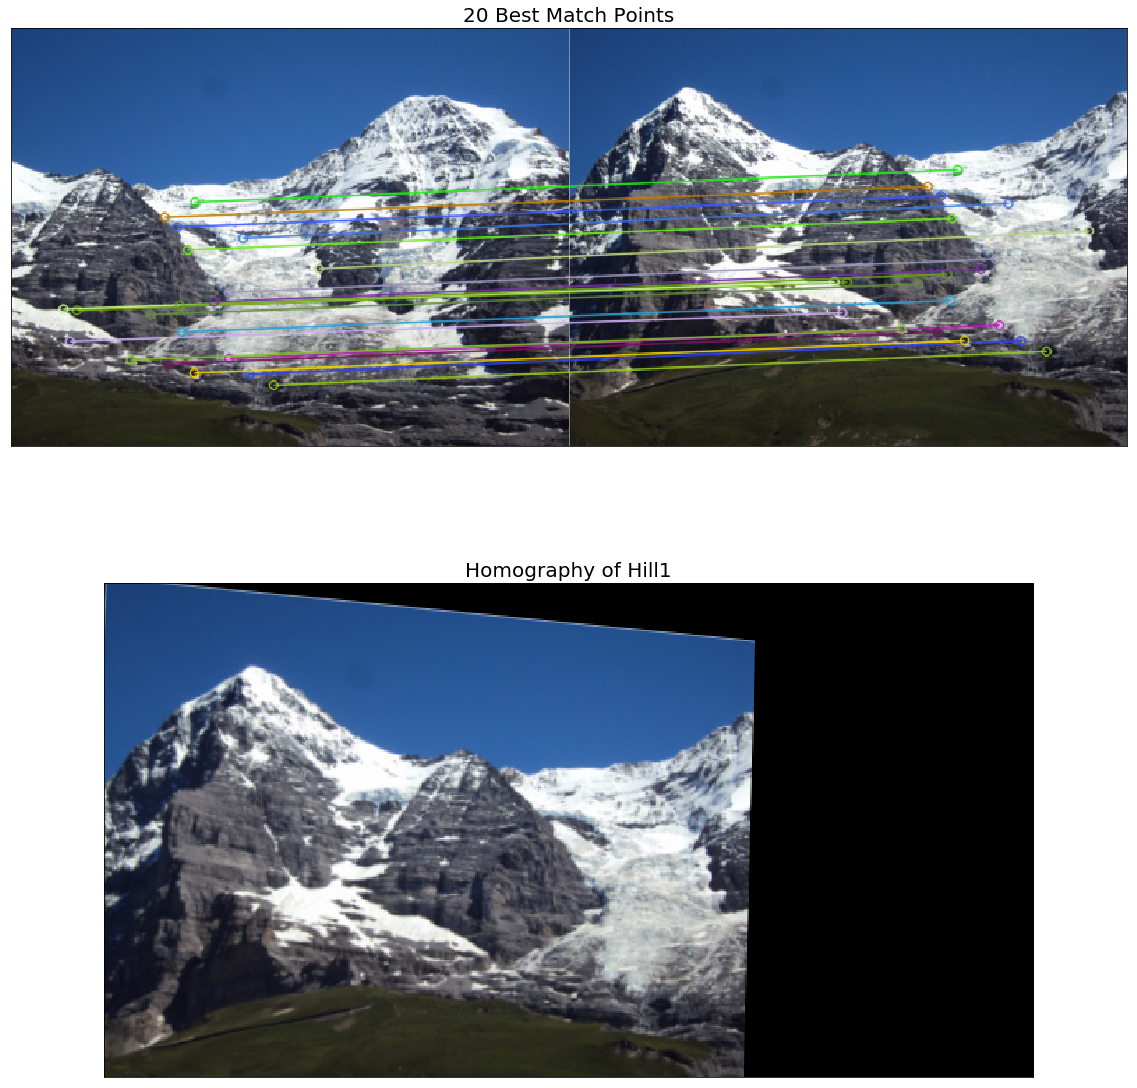

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
def warpPerspectivePadded(src, dst_shape, M):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    src : image to be warped.
    dst : shape of static image i.e. dst.shape 
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0]])
    # transform points
    transf_lin_pts = M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)

    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    if min_x < 0:
        anchor_x = -min_x
    shifted_transf = M + [[0, 0, anchor_x], [0, 0, 0], [0, 0, 0]]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + dst_w + max(max_x, dst_w) - dst_w
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped


img_Hill1 = cv2.cvtColor(cv2.imread("./stitching_images/1Hill.JPG"), cv2.COLOR_BGR2RGB)
img_Hill2 = cv2.cvtColor(cv2.imread("./stitching_images/2Hill.JPG"), cv2.COLOR_BGR2RGB)


img_Hill1_disp = img_Hill1.copy()
img_Hill2_disp = img_Hill2.copy()
img_Hill2_disp1 = img_Hill2.copy()

#1. Compute SIFT keypoints and corresponding discriptors
# create a SIFT object
sift1 = cv2.xfeatures2d.SIFT_create()   
surf1 = cv2.xfeatures2d.SURF_create()# Fot timing comparison

# detect SIFT features, with no masks
keypoints_Hill1_SIFT, descriptors_Hill1_SIFT = sift1.detectAndCompute(img_Hill1, None)
t1 = time.time()
keypoints_Hill2_SIFT, descriptors_Hill2_SIFT = sift1.detectAndCompute(img_Hill2, None)
t2 = time.time()
print("SIFT time:", t2-t1)

t3 = time.time()
keypoints_Hill2_SURF, descriptors_Hill2_SURF = surf1.detectAndCompute(img_Hill2, None)
t4 = time.time()
print("SURF time:", t4-t3)

# Draw keypoints 
cv2.drawKeypoints(img_Hill2, keypoints_Hill2_SIFT, img_Hill2_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_Hill2, keypoints_Hill2_SURF, img_Hill2_disp1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_Hill1, keypoints_Hill1_SIFT, img_Hill1_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#2. Find matching keypoints and display the 20 best pairs

# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(descriptors_Hill2_SIFT,descriptors_Hill1_SIFT)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Arrange matching keypoints in two separate lists
GoodPairs = []

for i, m in enumerate(matches):
    if m.distance < 100:
        GoodPairs.append(m)

# Draw match points
img_match = cv2.drawMatches(img_Hill2, keypoints_Hill2_SIFT, img_Hill1,keypoints_Hill1_SIFT, GoodPairs[:20], img_Hill1, flags=2)

mpr = np.float32([keypoints_Hill2_SIFT[m.queryIdx].pt for m in GoodPairs])
mp1 = np.float32([keypoints_Hill1_SIFT[m.trainIdx].pt for m in GoodPairs])


# 3. Find homography using RANSAC method and apply transformation to 1Hill.
H, __ = cv2.findHomography(mp1, mpr, cv2.RANSAC, 4) # have to use RANSAC for one of A2 questions
wimg = warpPerspectivePadded(img_Hill1,(img_Hill1.shape[0],img_Hill1.shape[1],3),H)
print(wimg.shape)
# plot
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(img_Hill1)
plt.title("img_Hill1",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_Hill1_disp)
plt.title("SIFT features of img_Hill1",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

print("SIFT and SURF comparison")
plt.figure(figsize=(20,20))
plt.subplot(141), plt.imshow(img_Hill2)
plt.title("img_Hill2",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.subplot(142), plt.imshow(img_Hill2_disp)
plt.title("SIFT features of img_Hill2",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.subplot(143), plt.imshow(img_Hill2_disp1)
plt.title("SURF features of img_Hill2",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(img_match)
plt.title("20 Best Match Points",fontsize = 20), plt.xticks([]), plt.yticks([])

plt.subplot(212), plt.imshow(wimg)
plt.title("Homography of Hill1",fontsize = 20), plt.xticks([]), plt.yticks([])
plt.show()

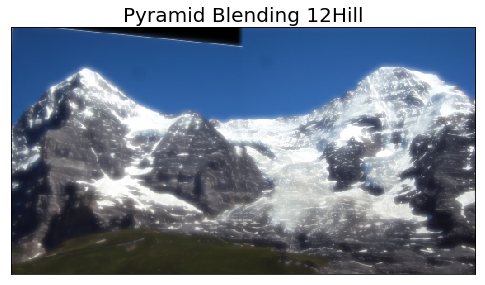

In [56]:
A = wimg.copy()
B = cv2.imread("./stitching_images/2Hill.JPG")

# Use copyMakeBorder function to resize Hill2 and fill the space with black
# copyMakeBorder( src, dst, top, bottom, left, right, borderType, value );
B = cv2.copyMakeBorder(B, 0, 0, (A.shape[1]-B.shape[1]) , 0, cv2.BORDER_CONSTANT,value=0)
A = cv2.cvtColor(A, cv2.COLOR_BGR2RGB)

# parameters
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size


""" PYRAMID BLENDING """
row, col, dpt = A.shape

# generate Image pyramid for imgA
G = A.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Image pyramid for imgB
G = B.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0])) #obtain lower reso pyramid
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# now reconstruct
Hill_12 = LP[0]
for i in range(1, depth):
    Hill_12 = cv2.pyrUp(Hill_12)  # upsample current lp image
    Hill_12 = cv2.add(Hill_12, LP[i])  # add lp image

# # now Gaussian mask reconstruct
# rs_mask = LP_mask[0]
# for i in range(1, depth):
#     rs_mask = cv2.pyrUp(rs_mask)  # upsample current lp image
#     rs_mask = cv2.add(rs_mask, LP_mask[i])  # add lp image

# display results
plt.figure(figsize=(10,10))
plt.subplot(211), plt.imshow(cv2.cvtColor(Hill_12, cv2.COLOR_RGB2BGR))
plt.title('Pyramid Blending 12Hill',fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()




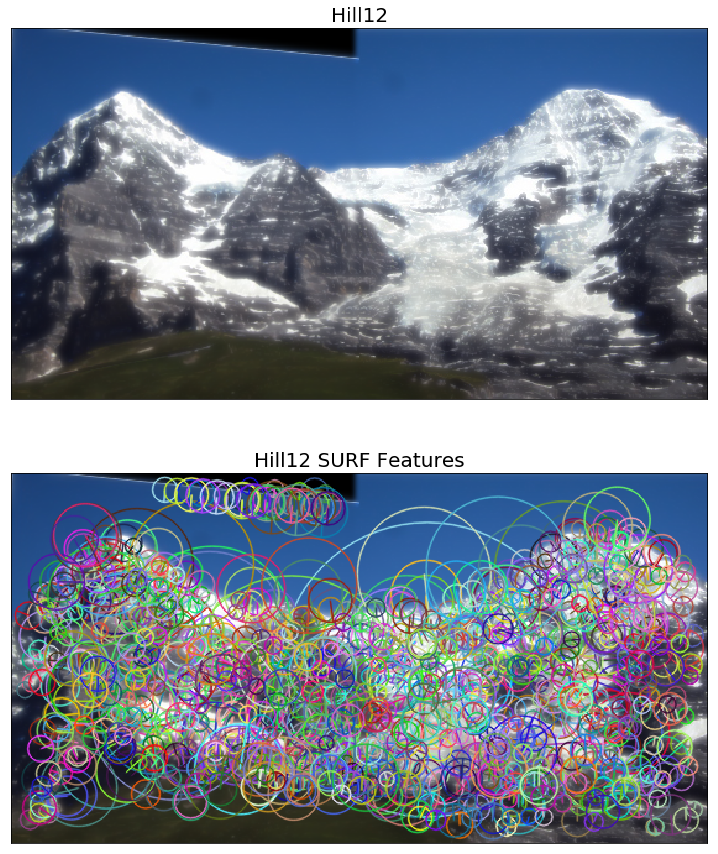

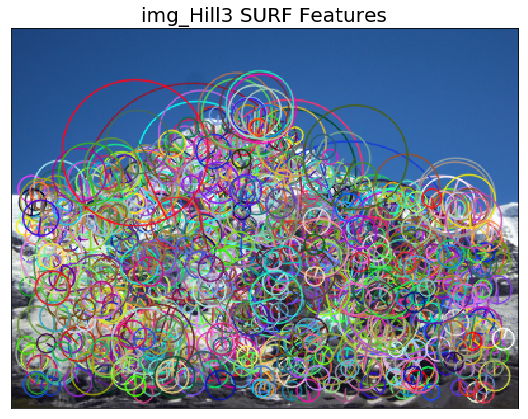

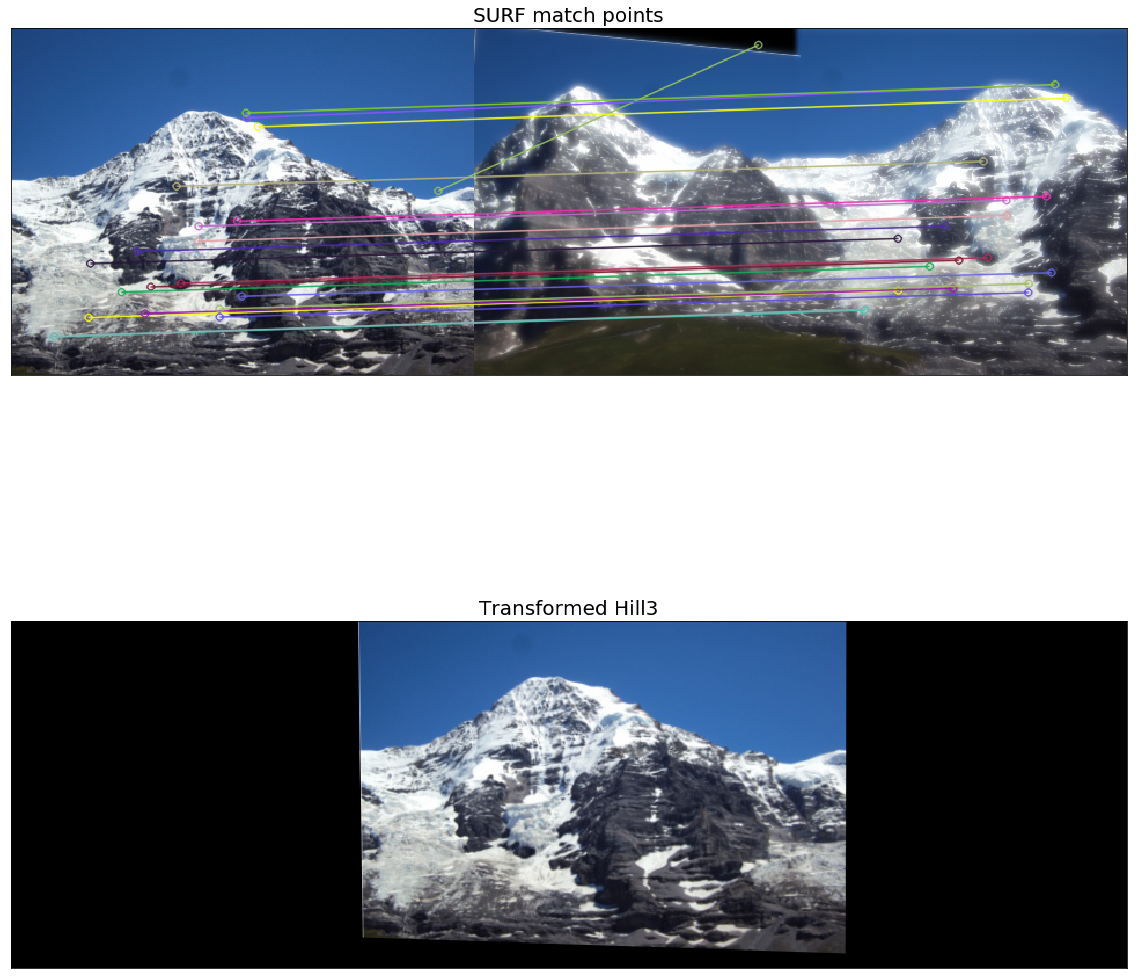

In [57]:

img_Hill3 = cv2.cvtColor(cv2.imread("./stitching_images/3Hill.JPG"), cv2.COLOR_BGR2RGB)
img_Hill12 = cv2.cvtColor(Hill_12, cv2.COLOR_BGR2RGB)


img_Hill3_disp = img_Hill3.copy()
img_Hill12_disp = img_Hill12.copy()

# create SURF object
surf = cv2.xfeatures2d.SURF_create()

# detect SURF features
keypoints_Hill12_SURF, descriptors_Hill12_SURF = surf.detectAndCompute(img_Hill12, None)
keypoints_Hill3_SURF, descriptors_Hill3_SURF = surf.detectAndCompute(img_Hill3, None)


# print("Number of SIFT keypoints for Hill3",len(keypoints_2_sift))
# print("Number of SURF keypoints for Hill3",len(keypoints_2_surf))


# draw keypoints
cv2.drawKeypoints(img_Hill12, keypoints_Hill12_SURF, img_Hill12_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img_Hill3, keypoints_Hill3_SURF, img_Hill3_disp, flags=4)

# create BFMatcher object
bf_surf = cv2.BFMatcher()

# Match descriptors.
matches_surf = bf.match(descriptors_Hill3_SURF,descriptors_Hill12_SURF)

# Sort them in the order of their distance.
matches_surf = sorted(matches_surf, key = lambda x:x.distance)

# Arrange matching keypoints in two separate lists
GoodPairs_surf = []
for i, m in enumerate(matches_surf):
    if m.distance <100:
        GoodPairs_surf.append(m)


# Draw match points
#imgmatch_surf = cv2.drawMatches(rs_mask,keypoints_1_surf,img_Hill3,keypoints_2_surf, GoodMatches_surf[:20], rs_mask, flags=2)
imgmatch_surf = cv2.drawMatches(img_Hill3, keypoints_Hill3_SURF, img_Hill12, keypoints_Hill12_SURF, GoodPairs_surf[:20], img_Hill3, flags=2)

mpr = np.float32([keypoints_Hill3_SURF[m.queryIdx].pt for m in GoodPairs_surf])
mp1 = np.float32([keypoints_Hill12_SURF[m.trainIdx].pt for m in GoodPairs_surf])
    
    
# # find homography and wrap image accordingly
H, __ = cv2.findHomography(mpr, mp1, cv2.RANSAC, 4) # have to use RANSAC for one of A2 questions

# apply perspective transform and padding to img_Hill3
wimg_surf = cv2.warpPerspective(img_Hill3, H, (img_Hill12.shape[1]+img_Hill3.shape[1],
                                               img_Hill12.shape[0]))

# display images
plt.figure(figsize=(15,15))
plt.subplot(211), plt.imshow(img_Hill12)
plt.title("Hill12", fontsize=20), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(img_Hill12_disp)
plt.title("Hill12 SURF Features",fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(122), plt.imshow(img_Hill3_disp)
plt.title("img_Hill3 SURF Features",fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(211), plt.imshow(imgmatch_surf)
plt.title("SURF match points", fontsize=20), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(wimg_surf)
plt.title("Transformed Hill3", fontsize=20), plt.xticks([]), plt.yticks([])
plt.show()

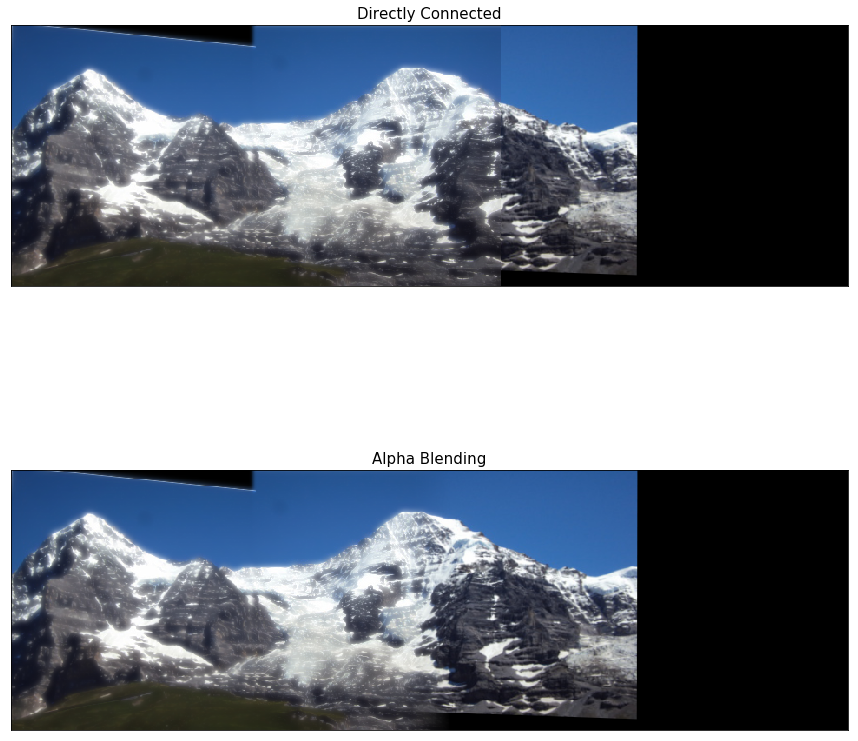

In [68]:
A_surf = rs.copy()
B_surf = wimg_surf.copy()

B_surf = cv2.cvtColor(B_surf, cv2.COLOR_BGR2RGB)

# image with direct connecting each half
real = np.hstack((A_surf[ :,:A_surf.shape[1]], B_surf[:, A_surf.shape[1]:]))

A_surf = cv2.copyMakeBorder(A_surf, 0, 0, 0,(B_surf.shape[1]-A_surf.shape[1]), cv2.BORDER_CONSTANT,value=0)

# width and height of image
col, row = A_surf.shape[0:2]



""" ALPHA BLENDING """
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp,539
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

# alpha blending ramp
ramp_size = 50  # alpha blending ramp size
alpha = Ramp(B_surf.shape[1], ramp_size, A_surf.shape[1]/2, 0, 1)


# Now blend
# print("alpha.reshape(1,-1,1)",1-alpha.reshape(1,-1,1)*A_surf)
I_blend = (1-alpha.reshape(1,-1,1))*A_surf + alpha.reshape(1,-1,1)*B_surf # use this for all mask

I_blend = np.uint8(I_blend)  # convert back to uint8


plt.figure(figsize=(15,15))
plt.subplot(211), plt.imshow(cv2.cvtColor(real, cv2.COLOR_RGB2BGR))
plt.title("Directly Connected", fontsize=15), plt.xticks([]), plt.yticks([])
plt.subplot(212), plt.imshow(cv2.cvtColor(I_blend, cv2.COLOR_RGB2BGR))
plt.title("Alpha Blending", fontsize=15), plt.xticks([]), plt.yticks([])
plt.show()

### 2.2 Reasoning Questions
#### 1. What are the differences between SIFT and SURF? Comment on the speed, number of keypoints and density. Support your arguments with statistics. (4 points)
SIFT time: 0.053166866302490234
SURF time: 0.04751086235046387 as shown above. Theoritically, the SURF is about 3-6 times faster than SIFT. Basically, SURF generates less keypoints than SIFT. 





#### 3. What would happen if a random subset of pairs of matching keypoints is used for finding homography? (2 points)
 As the homography depends on the matching point,



#### 4. Discuss the relationship between the number of pairs of matching keypoints used for finding homography and the accuracy of inferred homography. (2 points)
accurate because the homography is calculated using the 
More pairs generated the homography will be more accurate.



